<a href="https://colab.research.google.com/github/alina-bogdanovskaya/ML_in_Business_Mar2023/blob/lesson6/ML_in_business_HW06.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import roc_auc_score, log_loss, accuracy_score, recall_score, precision_score, f1_score
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
import lightgbm as lgb
from lightgbm import LGBMClassifier
import xgboost as xgb
from xgboost import XGBClassifier

# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [2]:
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X[self.column]
    

class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        
        for col_ in self.columns:
            if col_ not in test_columns:
                X[col_] = 0
        return X[self.columns]

In [23]:
def evaluate_results(y_test, y_pred):
    results={}
    print('Classification results:')
    f1 = f1_score(y_test, y_pred, zero_division=1)
    results['F1 score'] = f1
    print("f1: %.2f%%" % (f1 * 100.0)) 
    roc = roc_auc_score(y_test, y_pred)
    results['ROC_AUC'] = roc
    print("roc: %.2f%%" % (roc * 100.0)) 
    rec = recall_score(y_test, y_pred, average='binary', zero_division=1)
    results['Recall'] = rec
    print("recall: %.2f%%" % (rec * 100.0)) 
    prc = precision_score(y_test, y_pred, average='binary', zero_division=1)
    results['Precision'] = prc
    print("precision: %.2f%%" % (prc * 100.0)) 
    return results

In [4]:
data = pd.read_csv('/content/drive/MyDrive/GB/ML in business/datasets/HTRU2/HTRU_2.csv', header=None)

In [5]:
ds_columns=['Mean_integrated_profile', 'std_integrated_profile',
            'Excess_kurtosis_integrated_profile',
            'Skewness_integrated_profile', 'Mean_DM_SNR',
            'std_DM_SNR', 'Excess_kurtosis_DM_SNR', 
            'Skewness_DM_SNR', 'target_class']
data.columns = ds_columns

In [6]:
data.head()

,Mean_integrated_profile,std_integrated_profile,Excess_kurtosis_integrated_profile,Skewness_integrated_profile,Mean_DM_SNR,std_DM_SNR,Excess_kurtosis_DM_SNR,Skewness_DM_SNR,target_class
0,140.562500,55.683782,-0.234571,-0.699648,3.199833,19.110426,7.975532,74.242225,0
1,102.507812,58.882430,0.465318,-0.515088,1.677258,14.860146,10.576487,127.393580,0
2,103.015625,39.341649,0.323328,1.051164,3.121237,21.744669,7.735822,63.171909,0
3,136.750000,57.178449,-0.068415,-0.636238,3.642977,20.959280,6.896499,53.593661,0
4,88.726562,40.672225,0.600866,1.123492,1.178930,11.468720,14.269573,252.567306,0


In [7]:
data.describe()

,Mean_integrated_profile,std_integrated_profile,Excess_kurtosis_integrated_profile,Skewness_integrated_profile,Mean_DM_SNR,std_DM_SNR,Excess_kurtosis_DM_SNR,Skewness_DM_SNR,target_class
count,17898.000000,17898.000000,17898.000000,17898.000000,17898.000000,17898.000000,17898.000000,17898.000000,17898.000000
mean,111.079968,46.549532,0.477857,1.770279,12.614400,26.326515,8.303556,104.857709,0.091574
std,25.652935,6.843189,1.064040,6.167913,29.472897,19.470572,4.506092,106.514540,0.288432
min,5.812500,24.772042,-1.876011,-1.791886,0.213211,7.370432,-3.139270,-1.976976,0.000000
25%,100.929688,42.376018,0.027098,-0.188572,1.923077,14.437332,5.781506,34.960504,0.000000
50%,115.078125,46.947479,0.223240,0.198710,2.801839,18.461316,8.433515,83.064556,0.000000
75%,127.085938,51.023202,0.473325,0.927783,5.464256,28.428104,10.702959,139.309330,0.000000
max,192.617188,98.778911,8.069522,68.101622,223.392141,110.642211,34.539844,1191.000837,1.000000


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17898 entries, 0 to 17897
Data columns (total 9 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Mean_integrated_profile             17898 non-null  float64
 1   std_integrated_profile              17898 non-null  float64
 2   Excess_kurtosis_integrated_profile  17898 non-null  float64
 3   Skewness_integrated_profile         17898 non-null  float64
 4   Mean_DM_SNR                         17898 non-null  float64
 5   std_DM_SNR                          17898 non-null  float64
 6   Excess_kurtosis_DM_SNR              17898 non-null  float64
 7   Skewness_DM_SNR                     17898 non-null  float64
 8   target_class                        17898 non-null  int64  
dtypes: float64(8), int64(1)
memory usage: 1.2 MB


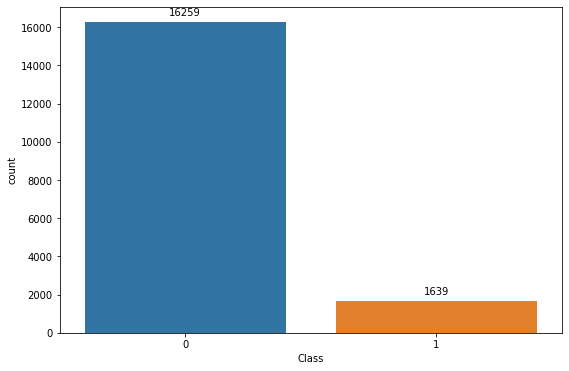

In [9]:
fig, axs = plt.subplots(figsize=(9, 6))
fg=sns.countplot(data=data, x='target_class')
fg.set_xlabel('Class')
for bars in axs.containers:
    axs.bar_label(bars, fmt='%1.f', padding=5)
plt.show()

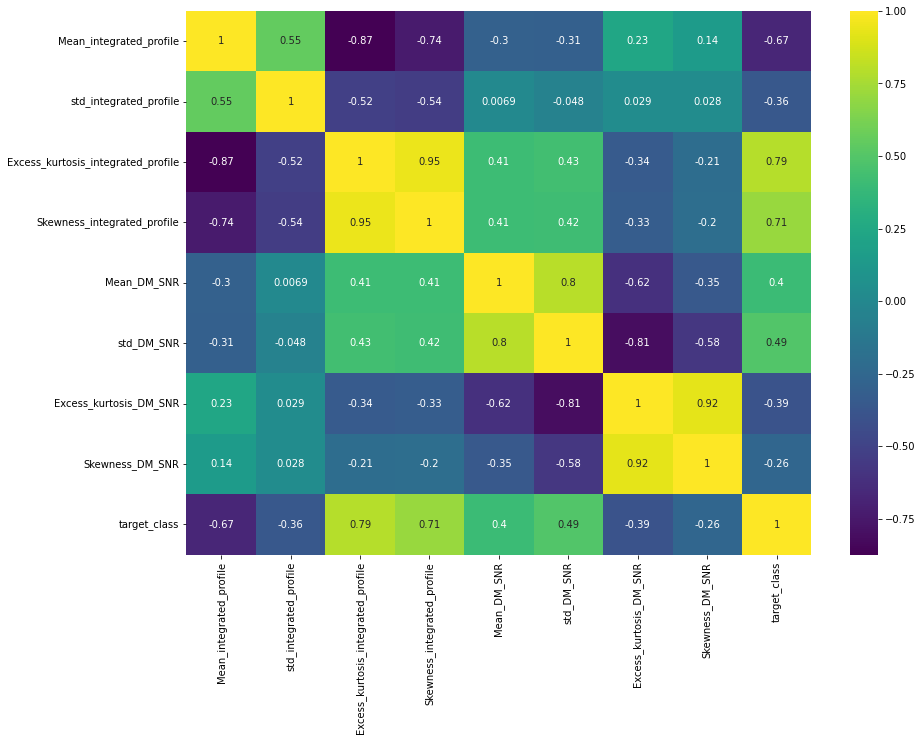

In [10]:
fig=plt.figure(figsize = (14, 10))
corr_mat = data.corr()
sns.heatmap(corr_mat, xticklabels = corr_mat.columns, cmap='viridis', yticklabels=corr_mat.columns, annot=True)
plt.show()

In [11]:
cont_columns = ['Mean_integrated_profile', 'std_integrated_profile',
                'Excess_kurtosis_integrated_profile',
                'Skewness_integrated_profile', 'Mean_DM_SNR',
                'std_DM_SNR', 'Excess_kurtosis_DM_SNR', 
                'Skewness_DM_SNR']

final_transformers = list()

for col in cont_columns:
    col_transformer = Pipeline([
                ('selector', NumberSelector(key=col)),
                ('standard', RobustScaler())
            ])
    
    final_transformers.append((col, col_transformer))

feats = FeatureUnion(final_transformers)

feature_processing = Pipeline([('feats', feats)])

In [12]:
X = data.drop(['target_class'], axis=1)
y = data.target_class

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=13)

In [24]:
model_lgbm = Pipeline([
    ('features', feats),
    ('classifier', LGBMClassifier())
])

model_lgbm.fit(X_train, y_train)
pred_lgbm = model_lgbm.predict(X_test)

metrics_labeled = evaluate_results(y_test, pred_lgbm)

Classification results:
f1: 88.95%
roc: 92.48%
recall: 85.64%
precision: 92.51%


In [36]:
data_mod = data.copy()

# get the indices of the positive samples
pos_ind = data_mod.index[data_mod.target_class == 1].tolist()

# shuffle them
np.random.shuffle(pos_ind)

# leave just x% of the positive marked
perc = 0.2
pos_sample_len = int(np.ceil(perc * len(pos_ind)))
pos_sample = pos_ind[:pos_sample_len]
print(f'Using {pos_sample_len}/{len(pos_ind)} as positives and unlabeling the rest')

data_mod['class_test'] = -1
data_mod.loc[pos_sample, 'class_test'] = 1
data_mod.class_test.value_counts()

Using 241/1204 as positives and unlabeling the rest


-1    16837
 1      241
Name: class_test, dtype: int64

In [15]:
data_mod.head(5)

,Mean_integrated_profile,std_integrated_profile,Excess_kurtosis_integrated_profile,Skewness_integrated_profile,Mean_DM_SNR,std_DM_SNR,Excess_kurtosis_DM_SNR,Skewness_DM_SNR,target_class,class_test
0,140.562500,55.683782,-0.234571,-0.699648,3.199833,19.110426,7.975532,74.242225,0,-1
1,102.507812,58.882430,0.465318,-0.515088,1.677258,14.860146,10.576487,127.393580,0,-1
2,103.015625,39.341649,0.323328,1.051164,3.121237,21.744669,7.735822,63.171909,0,-1
3,136.750000,57.178449,-0.068415,-0.636238,3.642977,20.959280,6.896499,53.593661,0,-1
4,88.726562,40.672225,0.600866,1.123492,1.178930,11.468720,14.269573,252.567306,0,-1


In [37]:
mod_data = data_mod.sample(frac=1)

data_U = mod_data[mod_data['class_test'] == -1]
data_P = mod_data[mod_data['class_test'] == 1]

neg_sample = data_U[:data_P.shape[0]]
pos_sample = data_P.copy()

sample_test = data_U[data_P.shape[0]:]
sample_train = pd.concat([neg_sample, pos_sample]).sample(frac=1)

In [38]:
sample_train.class_test.value_counts(), sample_train.target_class.value_counts() 

(-1    241
  1    241
 Name: class_test, dtype: int64, 1    257
 0    225
 Name: target_class, dtype: int64)

In [34]:
X_train_mod = sample_train.drop(['target_class', 'class_test'], axis=1)
y_train_mod = sample_train.target_class

X_test_mod = sample_test.drop(['target_class', 'class_test'], axis=1)
y_test_mod = sample_test.target_class 

In [25]:
model_lgbm = Pipeline([
    ('features', feats),
    ('classifier', LGBMClassifier())
])

model_lgbm.fit(X_train_mod, y_train_mod) 
             
pred_lgbm = model_lgbm.predict(X_test_mod)

metrics_rns25 = evaluate_results(y_test_mod, pred_lgbm)

Classification results:
f1: 75.29%
roc: 93.52%
recall: 90.86%
precision: 64.28%


In [31]:
model_lgbm = Pipeline([
    ('features', feats),
    ('classifier', LGBMClassifier())
])

model_lgbm.fit(X_train_mod, y_train_mod) 
             
pred_lgbm = model_lgbm.predict(X_test_mod)

metrics_rns50 = evaluate_results(y_test_mod, pred_lgbm)

Classification results:
f1: 56.08%
roc: 93.99%
recall: 93.18%
precision: 40.11%


In [35]:
model_lgbm = Pipeline([
    ('features', feats),
    ('classifier', LGBMClassifier())
])

model_lgbm.fit(X_train_mod, y_train_mod) 
             
pred_lgbm = model_lgbm.predict(X_test_mod)

metrics_rns33 = evaluate_results(y_test_mod, pred_lgbm)

Classification results:
f1: 63.14%
roc: 93.19%
recall: 91.33%
precision: 48.25%


In [39]:
model_lgbm = Pipeline([
    ('features', feats),
    ('classifier', LGBMClassifier())
])

model_lgbm.fit(X_train_mod, y_train_mod) 
             
pred_lgbm = model_lgbm.predict(X_test_mod)

metrics_rns20 = evaluate_results(y_test_mod, pred_lgbm)

Classification results:
f1: 63.14%
roc: 93.19%
recall: 91.33%
precision: 48.25%


In [19]:
data = sample_test.copy()
data['prediction'] = pd.Series(pred_lgbm)
data.head(10)

,Mean_integrated_profile,std_integrated_profile,Excess_kurtosis_integrated_profile,Skewness_integrated_profile,Mean_DM_SNR,std_DM_SNR,Excess_kurtosis_DM_SNR,Skewness_DM_SNR,target_class,class_test,prediction
16364,93.148438,51.911146,0.280705,-0.098378,2.096990,14.020313,9.972777,127.989888,0,-1,0.0
1416,126.984375,41.224042,-0.099490,0.987468,1.346990,15.772393,13.504034,190.966572,0,-1,0.0
14892,112.437500,45.766860,0.247305,0.291442,1.997492,18.948200,10.147888,106.665279,0,-1,0.0
15696,128.703125,42.327104,-0.051495,0.235410,3.006689,15.876982,7.946381,84.208458,0,-1,0.0
4568,118.515625,51.368762,0.353937,-0.270006,1.348662,13.094958,11.972218,169.598016,0,-1,0.0
6976,135.421875,49.863033,0.020081,-0.073447,0.576087,10.026973,20.397294,452.987176,0,-1,0.0
11644,139.992188,45.689081,0.071959,0.597103,2.752508,19.167689,9.020874,92.055197,0,-1,0.0
349,130.296875,43.724521,0.239300,0.773895,3.327759,21.938983,7.633628,63.687979,0,-1,1.0
15894,132.523438,42.947272,-0.193916,0.476484,1.751672,14.197757,12.011333,169.696484,0,-1,0.0
15855,101.945312,39.955309,0.359844,1.669114,2.191472,15.385002,10.157737,120.795529,0,-1,0.0


In [43]:
metrics = pd.DataFrame.from_dict([metrics_labeled, 
                                  metrics_rns25, 
                                  metrics_rns50, 
                                  metrics_rns33, 
                                  metrics_rns20])
metrics.insert(0, 'data', ['labeled data', 'P = 0.25', 'P = 0.50', 'P = 0.33', 'P = 0.20'])
metrics

,data,F1 score,ROC_AUC,Recall,Precision
0,labeled data,0.889460,0.924779,0.856436,0.925134
1,P = 0.25,0.752925,0.935168,0.908638,0.642773
2,P = 0.50,0.560757,0.939899,0.931818,0.401053
3,P = 0.33,0.631393,0.931855,0.913265,0.482480
4,P = 0.20,0.631393,0.931855,0.913265,0.482480
